# Natural Language Processing with Disaster Tweets
### Author: Blu LeBlanc
https://github.com/Blu-LeBlanc/Deep-Learning-Projects

Note: Adapted this notebook from the starter notebook provided by Keras team.

## Project Description

In this competition, the challenge is to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t.
A dataset of 10,000 tweets that were hand classified is available. 

I decided to use a transformer sequence classification model provided by Hugging Face


In [1]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Hugging Face
from transformers import TFDistilBertForSequenceClassification, DistilBertTokenizer
# Word Cloud
from wordcloud import WordCloud
# Cleaning
import re
from sklearn.metrics import f1_score

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)
#print("KerasNLP version:", keras_nlp.__version__)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

TensorFlow version: 2.12.0
Keras version: 2.12.0


## Data Description
Let's have a look at the train and test dataset.

They contain:
- id
- keyword: A keyword from that tweet (although this may be blank!)
- location: The location the tweet was sent from (may also be blank)
- text: The text of a tweet
- target: 1 if the tweet is a real disaster or 0 if not

In [3]:
train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

print('Training Set Shape = {}'.format(train_df.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(train_df.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(test_df.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(test_df.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


In [4]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


## Exploratory Data Analysis

In [6]:
train_df["length"] = train_df["text"].apply(lambda x : len(x))
test_df["length"] = test_df["text"].apply(lambda x : len(x))

print("Train Length Stat")
print(train_df["length"].describe())
print()

print("Test Length Stat")
print(test_df["length"].describe())

Train Length Stat
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

Test Length Stat
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64


Note that all the tweets are in english. I processed the data beforehand and set up some of my hyperparameter values that I can tweak to improve performance

### Preprocess the data

In [7]:
# Hyperparameters
BATCH_SIZE = 16
NUM_TRAINING_EXAMPLES = train_df.shape[0]
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES)*TRAIN_SPLIT // BATCH_SIZE

# EPOCHS = 2
EPOCHS = 3
AUTO = tf.data.experimental.AUTOTUNE

In [8]:
# Set up my train_test_split
from sklearn.model_selection import train_test_split

X = train_df["text"]
y = train_df["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42)

X_test = test_df["text"]

### EDA Visuals

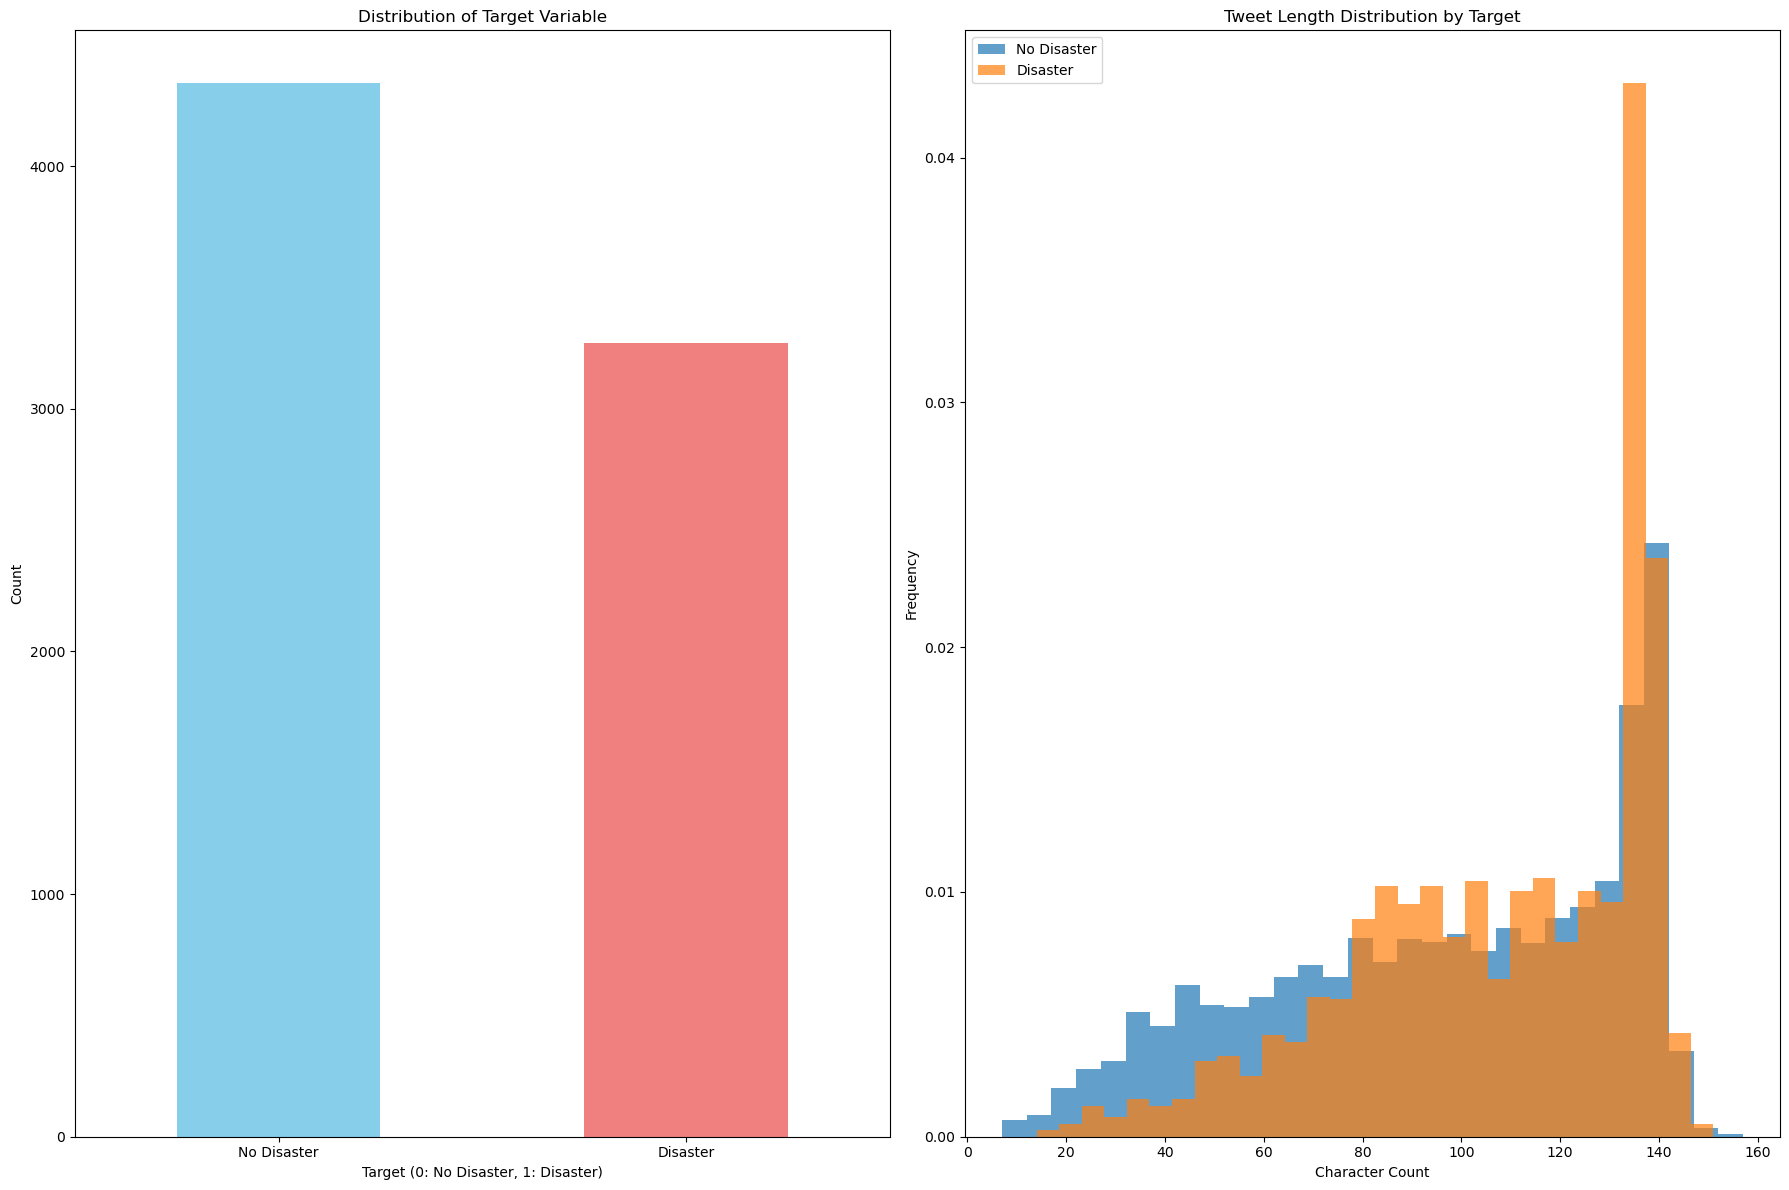


Generating word clouds for each class...


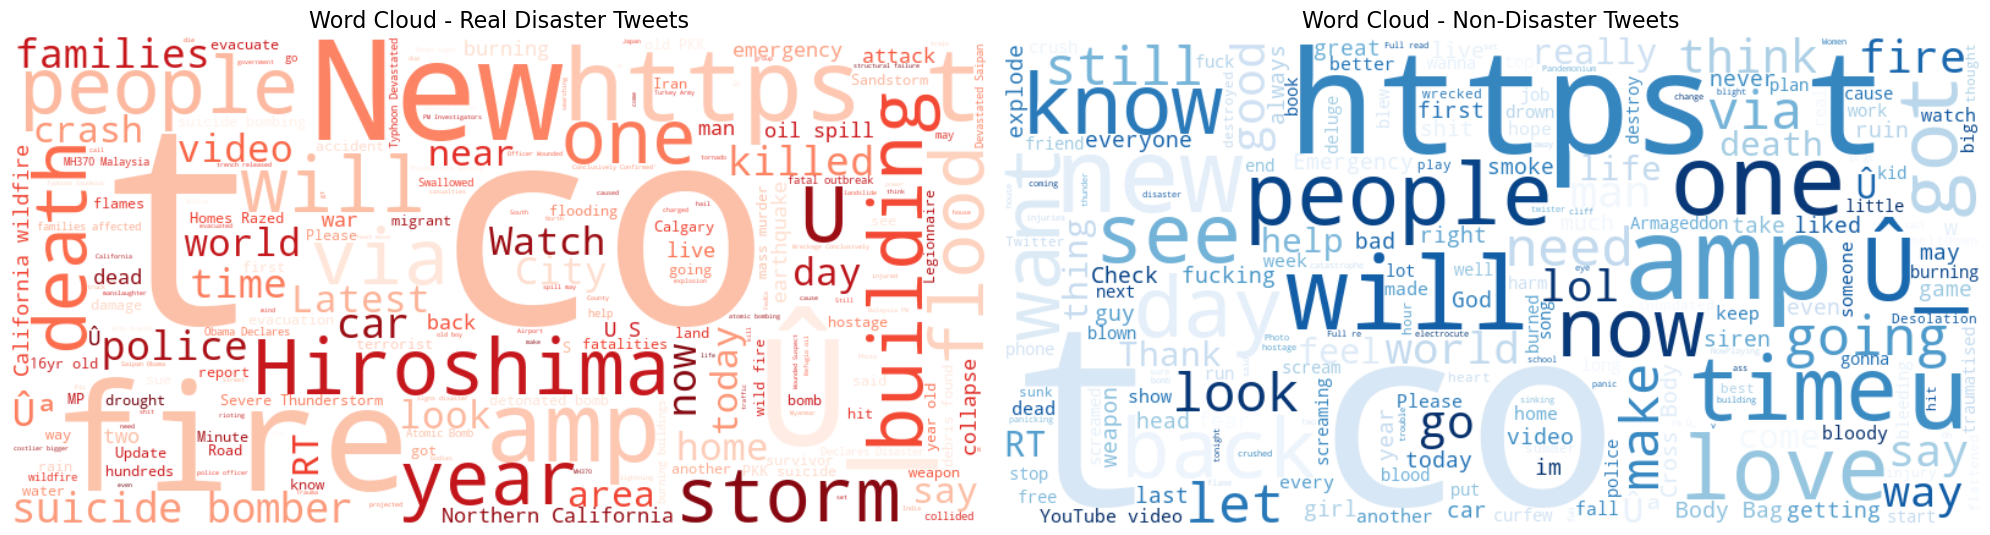

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(18, 12))

# distribution of target variable
train_df['target'].value_counts().plot(kind='bar', ax=axes[0], color=['skyblue', 'lightcoral'])
axes[0].set_title('Distribution of Target Variable')
axes[0].set_xlabel('Target (0: No Disaster, 1: Disaster)')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['No Disaster', 'Disaster'], rotation=0)

# Tweet Length
train_df['text_length'] = train_df['text'].apply(len)
train_df.groupby('target')['text_length'].plot(kind='hist', alpha=0.7, bins=30, ax=axes[1], 
                                               legend=True, density=True)
axes[1].set_title('Tweet Length Distribution by Target')
axes[1].set_xlabel('Character Count')
axes[1].legend(['No Disaster', 'Disaster'])

plt.tight_layout()
plt.show()

# Word clouds
print("\nGenerating word clouds for each class...")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Disaster tweets word cloud
disaster_text = ' '.join(train_df[train_df['target']==1]['text'].values)
wordcloud_disaster = WordCloud(width=800, height=400, background_color='white', 
                              colormap='Reds').generate(disaster_text)
ax1.imshow(wordcloud_disaster, interpolation='bilinear')
ax1.set_title('Word Cloud - Real Disaster Tweets', fontsize=16)
ax1.axis('off')

# Non-disaster tweets word cloud
non_disaster_text = ' '.join(train_df[train_df['target']==0]['text'].values)
wordcloud_non_disaster = WordCloud(width=800, height=400, background_color='white', 
                                  colormap='Blues').generate(non_disaster_text)
ax2.imshow(wordcloud_non_disaster, interpolation='bilinear')
ax2.set_title('Word Cloud - Non-Disaster Tweets', fontsize=16)
ax2.axis('off')

plt.tight_layout()
plt.show()

From our distribution of the target variable, we see that there is more 0s than 1s. The target count is slightly unbalanced. There isn't any useful information from tweet duration. From the word clouds, I am considering removing t.co which refers to posted url links. Regardless I need to do some text cleaning before my analysis.

### Cleaning Data
I ran minimal cleaning just removing text relating to URLs


Generating word clouds for each class...


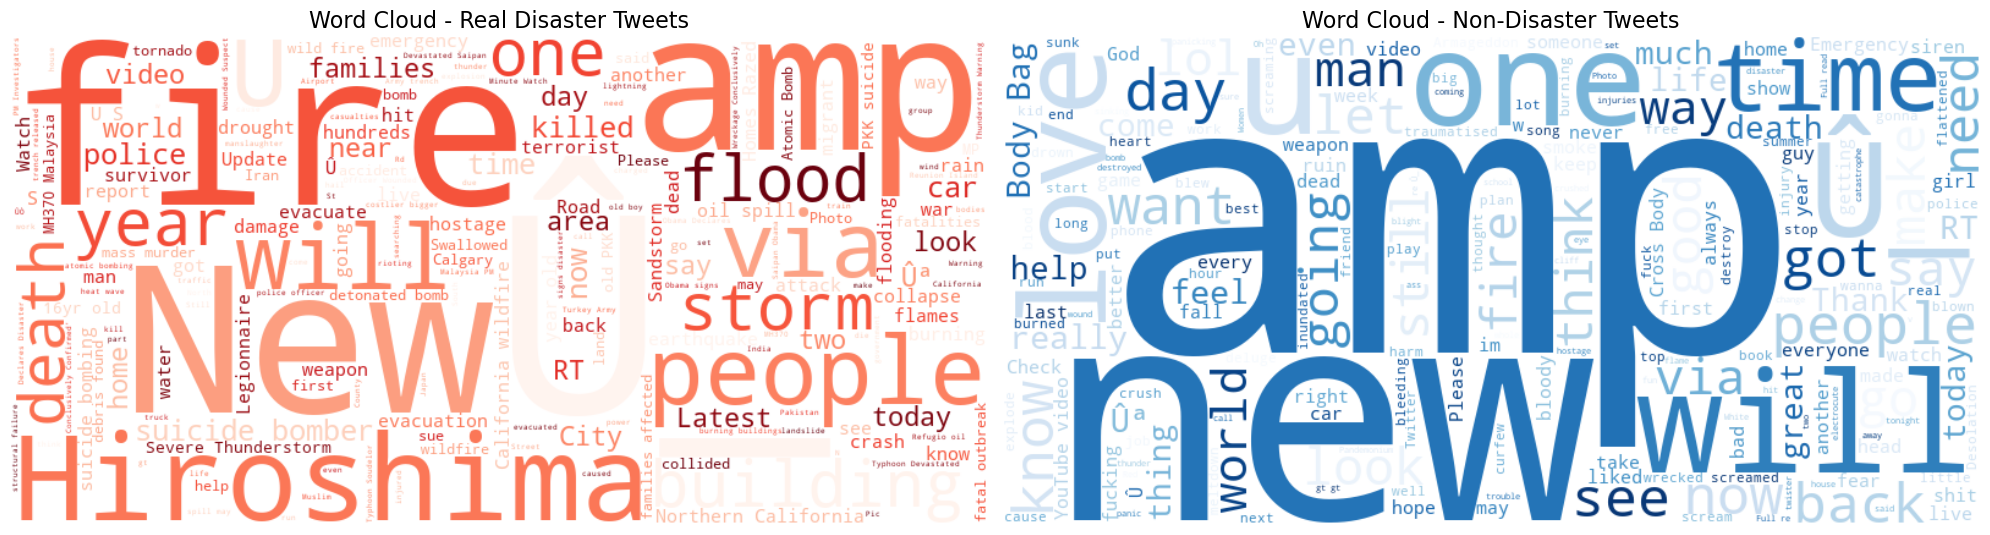

In [10]:
def clean_text(text):
    if pd.isna(text):
        return ""
    text = str(text)
    # HTML
    text = re.sub(r'<.*?>', ' ', text)
    # URL
    text = re.sub(r'http\S+|www.\S+', ' ', text)
    # Clean whitespace
    text = ' '.join(text.split())
    return text

train_df['cleaned_text'] = train_df['text'].apply(clean_text)
test_df['cleaned_text'] = test_df['text'].apply(clean_text)

# Word clouds
print("\nGenerating word clouds for each class...")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Disaster tweets word cloud
disaster_text = ' '.join(train_df[train_df['target']==1]['cleaned_text'].values)
wordcloud_disaster = WordCloud(width=800, height=400, background_color='white', 
                              colormap='Reds').generate(disaster_text)
ax1.imshow(wordcloud_disaster, interpolation='bilinear')
ax1.set_title('Word Cloud - Real Disaster Tweets', fontsize=16)
ax1.axis('off')

# Non-disaster tweets word cloud
non_disaster_text = ' '.join(train_df[train_df['target']==0]['cleaned_text'].values)
wordcloud_non_disaster = WordCloud(width=800, height=400, background_color='white', 
                                  colormap='Blues').generate(non_disaster_text)
ax2.imshow(wordcloud_non_disaster, interpolation='bilinear')
ax2.set_title('Word Cloud - Non-Disaster Tweets', fontsize=16)
ax2.axis('off')

plt.tight_layout()
plt.show()

### Tokenize

We are using a Bert model structure from Hugging Face. To fully process the data, we need to tokenize the text

In [11]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def tokenize_data(texts, max_length=128):
    return tokenizer(
        texts.tolist(),
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )
    



train_tokend = tokenize_data(X_train.apply(clean_text))
val_tokend = tokenize_data(X_val.apply(clean_text))
test_tokend = tokenize_data(X_test.apply(clean_text))

## Model Architecture
The starter notebook that I based this notebook on suggested using BERT. I decided to try this method by using Hugging Face Transformers and using a Binary Classification Model. BERT is a transformer based language model that is pre-trained on a massive amount of text data to understand language context. It is a free and convenient tool that gives strong performance for binary classification of text. One benefit of this method is that I do not have to do much text cleaning.

In [12]:
# Binary Classification Model

model = TFDistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=2  # Binary classification
)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

### Train Model

In [13]:

train_labels = train_df['target'].values

# Use tensorflow dataset for training

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_tokend),
    y_train.values
)).shuffle(1000).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_tokend),
    y_val.values
)).batch(BATCH_SIZE)

# F1 score
class F1ScoreCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_data, val_labels):
        super().__init__()
        self.val_data = val_data
        self.val_labels = val_labels
        self.best_f1 = 0
        
    def on_epoch_end(self, epoch, logs=None):
        predictions = self.model.predict(self.val_data, verbose=0)
        pred_classes = np.argmax(predictions.logits, axis=1)
        f1 = f1_score(self.val_labels, pred_classes)
        print(f' - val_f1: {f1:.4f}')
        
        if f1 > self.best_f1:
            self.best_f1 = f1

# Initialize callback with validation data
f1_callback = F1ScoreCallback(
    dict(val_tokend),
    y_val.values
)




# Compile
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 2e-5), # ADJUST LEARNING RATE IF NEEDED
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),# 'binary_crossentropy'
    metrics = ['accuracy']
)

# Train the model
history = model.fit(#x=X_train,
                         train_dataset,
                         # batch_size=BATCH_SIZE,
                         epochs=EPOCHS,
                         validation_data=val_dataset,
                         callbacks = [f1_callback],
                         verbose = 1
                        )

print(f"Best validation F1: {f1_callback.best_f1:.4f}")

Epoch 1/3
381/381 [==============================] - 97s 192ms/step - loss: 0.4451 - accuracy: 0.8069 - val_loss: 0.3897 - val_accuracy: 0.8378
Epoch 2/3
381/381 [==============================] - 59s 156ms/step - loss: 0.3253 - accuracy: 0.8722 - val_loss: 0.4033 - val_accuracy: 0.8319
Epoch 3/3
381/381 [==============================] - 58s 153ms/step - loss: 0.2342 - accuracy: 0.9105 - val_loss: 0.4438 - val_accuracy: 0.8201
Best validation F1: 0.8047


## Results and Analysis
I am already impressed with the current strength of the model. Due to the target variable imbalance, and since I am doing binary classification, I have decided to focus on F1 score for model optimization. Below I have created a grid with a variety of hyperparameter values (learning_rate, batch_size, epochs) and will determine the best values for performance. To improve the time it takes, I added early stopping

In [14]:
from itertools import product
import time

# hyperparameter grid
param_grid = {
    'learning_rate': [1e-5, 3e-5],
    'batch_size': [8, 32]
}
epochs = 3

# function to train model with params
def train_with_params(learning_rate, batch_size, epochs, max_length = 128):
    print(f"\nTraining with LR={learning_rate}, Batch={batch_size}, Epochs={epochs}")
    
    # batch size
    train_dataset = tf.data.Dataset.from_tensor_slices((
        dict(train_tokend),
        y_train.values
    )).shuffle(1000).batch(batch_size)
    
    val_dataset = tf.data.Dataset.from_tensor_slices((
        dict(val_tokend),
        y_val.values
    )).batch(batch_size)
    
    # new model
    model = TFDistilBertForSequenceClassification.from_pretrained(
        'distilbert-base-uncased',
        num_labels=2
    )
    
    # learning rate
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    
    # F1 callback for this run
    f1_callback = F1ScoreCallback(
        dict(val_tokend),
        y_val.values
    )
    
    # Train
    start_time = time.time()
    history = model.fit(
        train_dataset,
        epochs=epochs,
        validation_data=val_dataset,
        callbacks=[f1_callback],
        verbose=0  
    )
    training_time = time.time() - start_time
    
    # final metrics
    final_val_acc = history.history['val_accuracy'][-1]
    
    return {
        'learning_rate': learning_rate,
        'batch_size': batch_size,
        'epochs': epochs,
        'f1_score': f1_callback.best_f1,
        'val_accuracy': final_val_acc,
        'training_time': training_time,
        'model': model 
    }

# hyperparam search
results = []

for lr, batch_size in product(param_grid['learning_rate'], 
                                      param_grid['batch_size']):
    result = train_with_params(lr, batch_size, epochs)
    results.append(result)
    
    print(f"F1 Score: {result['f1_score']:.4f}")

# results dataframe
results_df = pd.DataFrame(results)

# sort by F1 score
results_df = results_df.sort_values('f1_score', ascending=False)

# Display results table
display_df = results_df[['learning_rate', 'batch_size', 'epochs', 'f1_score', 'val_accuracy', 'training_time']]
display_df['training_time'] = display_df['training_time'].round(1)
display_df['f1_score'] = display_df['f1_score'].round(4)
display_df['val_accuracy'] = display_df['val_accuracy'].round(4)

print("\n" + "="*80)
print("HYPERPARAMETER TUNING RESULTS (Sorted by F1 Score)")
print("="*80)
print(display_df.to_string(index=False))

# Get best model
best_idx = results_df['f1_score'].idxmax()
best_result = results_df.loc[best_idx]
best_model = best_result['model']

print("\n" + "="*80)
print("BEST MODEL CONFIGURATION")
print("="*80)
print(f"Learning Rate: {best_result['learning_rate']}")
print(f"Batch Size: {best_result['batch_size']}")
print(f"Epochs: {best_result['epochs']}")
print(f"F1 Score: {best_result['f1_score']:.4f}")
print(f"Validation Accuracy: {best_result['val_accuracy']:.4f}")
print(f"Training Time: {best_result['training_time']:.1f} seconds")
    


Training with LR=1e-05, Batch=8, Epochs=3


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

 - val_f1: 0.8064
 - val_f1: 0.8057
 - val_f1: 0.7978
F1 Score: 0.8064

Training with LR=1e-05, Batch=32, Epochs=3


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

 - val_f1: 0.7858
 - val_f1: 0.7903
 - val_f1: 0.8003
F1 Score: 0.8003

Training with LR=3e-05, Batch=8, Epochs=3


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

 - val_f1: 0.7949
 - val_f1: 0.7835
 - val_f1: 0.7769
F1 Score: 0.7949

Training with LR=3e-05, Batch=32, Epochs=3


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

 - val_f1: 0.7943
 - val_f1: 0.7843
 - val_f1: 0.7883
F1 Score: 0.7943

HYPERPARAMETER TUNING RESULTS (Sorted by F1 Score)
 learning_rate  batch_size  epochs  f1_score  val_accuracy  training_time
       0.00001           8       3    0.8064        0.8299          237.2
       0.00001          32       3    0.8003        0.8339          187.2
       0.00003           8       3    0.7949        0.8122          231.2
       0.00003          32       3    0.7943        0.8201          180.2

BEST MODEL CONFIGURATION
Learning Rate: 1e-05
Batch Size: 8
Epochs: 3
F1 Score: 0.8064
Validation Accuracy: 0.8299
Training Time: 237.2 seconds


/tmp/ipykernel_26/73401038.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  display_df['training_time'] = display_df['training_time'].round(1)
/tmp/ipykernel_26/73401038.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  display_df['f1_score'] = display_df['f1_score'].round(4)
/tmp/ipykernel_26/73401038.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:/

## Predictions

After optimization, we choose the best model for making our predictions

In [15]:
print("Making Predictions...")
predictions = best_model.predict(dict(test_tokend))

# Get Predicted class (0 or 1)
predicted_class = np.argmax(predictions.logits, axis = 1)

# Get Probability Score
probabilities = tf.nn.softmax(predictions.logits, axis = 1).numpy()
positive_probabilities = probabilities[:, 1]  # Probability of 1 class

test_df['prediction'] = predicted_class
test_df['probability'] = positive_probabilities

#y_pred_train = classifier.predict(X_train)

#displayConfusionMatrix(y_train, y_pred_train, "Training")

Making Predictions...
102/102 [==============================] - 8s 80ms/step


In [16]:
#y_pred_val = classifier.predict(X_val)

#displayConfusionMatrix(y_val, y_pred_val, "Validation")

## Generate the submission file 

For each tweets in the test set, we predict if the given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

The submission.csv file uses the following format:
id,target

In [17]:
sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [18]:
#sample_submission["target"] = np.argmax(classifier.predict(X_test), axis=1)

submission = pd.DataFrame({
    'id': test_df['id'],  # or whatever your ID column is
    'target': predicted_class  # or 'target', depending on competition
})
submission.to_csv('submission.csv', index=False)

In [19]:
new_submission = pd.read_csv('/kaggle/working/submission.csv')
new_submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


## Conclusion
For optimization, I found that increasing the batch size to 32 and decreasing the learning rate from 0.00002 to 0.00001 improved the accuracy of the model, but only slightly. It seems my model was already very accurate as is, and other optimization things such as different text cleaning or different models might give better improvements. It feels very hard to do model optimization due to the time commitment it takes. I had to reduce the number of options for my grid values because of the computation time. I believe other methods, such as random sampling of learning values, might be more effective than grid optimization. Overall, this project taught me a lot about how nlp analysis can be done and what steps need to be taken before creating the model. I also learned how powerful of a tool the Hugging Face library is for nlp related tasks.